In [1]:
import openslide
import numpy as np
from PIL import Image
import os
import json
from glob import glob
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import yaml
from torch.utils import data
# 개별 json 라벨 파일을 이용해 학습 데이터 리스트 생성
import json
import os
from nets import nn
from utils import util
from utils.dataset import Dataset
from torch.utils import data
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision
from torch.nn.functional import cross_entropy
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:",device)
params={'names':{
  0: 'pd-l1 negative tumor cell',
  1: 'pd-l1 positive tumor cell',
  2: 'non-tumor cell'}}

device: cuda:0


In [3]:
save_dir='../../model/yolov11/'
model = nn.yolo_v11_x(len(params['names'])).to(device)
checkpoint_path = os.path.join(save_dir, 'best_model.pt')
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device,weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])

def visualize_detection_results(image, outputs, title="Cell Detection Results"):
    """
    검출 결과를 이미지에 시각화하는 함수
    
    Args:
        image: PIL Image 또는 numpy array
        outputs: (negative_tumor, positive_tumor, non_tumor) 튜플
        title: 플롯 제목
    """
    negative_tumor, positive_tumor, non_tumor = outputs
    
    # 이미지를 numpy array로 변환
    if hasattr(image, 'convert'):  # PIL Image인 경우
        img_array = np.array(image.convert('RGB'))
    else:  # 이미 numpy array인 경우
        img_array = image
    
    # 플롯 생성
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(img_array)
    
    # 각 클래스별로 다른 색상과 마커로 표시
    colors = {
        'negative': 'red',      # pd-l1 negative tumor cell
        'positive': 'blue',     # pd-l1 positive tumor cell  
        'non_tumor': 'green'    # non-tumor cell
    }
    
    markers = {
        'negative': 'o',
        'positive': 's', 
        'non_tumor': '^'
    }
    
    # 이미지 크기 (검출은 512x512에서 수행됨)
    img_height, img_width = img_array.shape[:2]
    
    # Negative tumor cells 표시
    if negative_tumor:
        for cell in negative_tumor:
            x, y = cell['x'], cell['y']
            # 좌표를 이미지 크기에 맞게 스케일링 (필요시)
            x_scaled = x * (img_width / 512) if img_width != 512 else x
            y_scaled = y * (img_height / 512) if img_height != 512 else y
            
            ax.plot(x_scaled, y_scaled, markers['negative'], 
                   color=colors['negative'], markersize=8, alpha=0.7,
                   label='PD-L1 Negative' if cell == negative_tumor[0] else "")
    
    # Positive tumor cells 표시  
    if positive_tumor:
        for cell in positive_tumor:
            x, y = cell['x'], cell['y']
            x_scaled = x * (img_width / 512) if img_width != 512 else x
            y_scaled = y * (img_height / 512) if img_height != 512 else y
            
            ax.plot(x_scaled, y_scaled, markers['positive'], 
                   color=colors['positive'], markersize=8, alpha=0.7,
                   label='PD-L1 Positive' if cell == positive_tumor[0] else "")
    
    # # Non-tumor cells 표시
    # if non_tumor:
    #     for cell in non_tumor:
    #         x, y = cell['x'], cell['y']
    #         x_scaled = x * (img_width / 512) if img_width != 512 else x
    #         y_scaled = y * (img_height / 512) if img_height != 512 else y
            
    #         ax.plot(x_scaled, y_scaled, markers['non_tumor'], 
    #                color=colors['non_tumor'], markersize=8, alpha=0.7,
    #                label='Non-tumor' if cell == non_tumor[0] else "")
    
    # 범례 추가
    ax.legend(loc='upper right', bbox_to_anchor=(1, 1))
    
    # 축 설정
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('X coordinate', fontsize=12)
    ax.set_ylabel('Y coordinate', fontsize=12)
    
    # 검출 통계 정보 추가
    stats_text = f'Detected cells:\n'
    stats_text += f'PD-L1 Negative: {len(negative_tumor)}\n'
    stats_text += f'PD-L1 Positive: {len(positive_tumor)}\n' 
    # stats_text += f'Non-tumor: {len(non_tumor)}\n'
    stats_text += f'Total: {len(negative_tumor) + len(positive_tumor)}'
    
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
           verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return fig, ax

def wh2xy(x):
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 0] = x[:, 0] - x[:, 2] / 2  # top left x
    y[:, 1] = x[:, 1] - x[:, 3] / 2  # top left y
    y[:, 2] = x[:, 0] + x[:, 2] / 2  # bottom right x
    y[:, 3] = x[:, 1] + x[:, 3] / 2  # bottom right y
    return y

def non_max_suppression(outputs, confidence_threshold=0.001, iou_threshold=0.65, class_thresholds=None, 
                        cross_class_nms=True, cross_class_iou_threshold=0.5):
    """
    개선된 NMS - 클래스 내부 + 클래스 간 겹침 제거
    
    Args:
        outputs: 모델 출력
        confidence_threshold: 기본 confidence threshold
        iou_threshold: 같은 클래스 내 NMS IoU threshold
        class_thresholds: 클래스별 개별 threshold 딕셔너리
        cross_class_nms: 다른 클래스 간 NMS 적용 여부
        cross_class_iou_threshold: 다른 클래스 간 NMS IoU threshold
    """
    max_wh = 4096      # 512x512 패치에 충분한 오프셋 (기존 7680에서 줄임)
    max_det = 500      # 세포가 많을 수 있으므로 300 → 500으로 증가
    max_nms = 10000 

    bs = outputs.shape[0]
    nc = outputs.shape[1] - 4
    
    # 빠른 필터링을 위해 가장 낮은 threshold 사용
    min_conf = confidence_threshold
    if class_thresholds:
        min_conf = min(min(class_thresholds.values()), confidence_threshold)
    
    # 전체 confidence가 낮은 것들 먼저 제거
    xc = outputs[:, 4:4 + nc].amax(1) > min_conf
    
    output = [torch.zeros((0, 6), device=outputs.device)] * bs
    
    for xi, x in enumerate(outputs):  # image index, image inference
        x = x.transpose(0, -1)[xc[xi]]
        
        if not x.shape[0]:
            continue

        # 박스와 클래스 분리
        box, cls = x.split((4, nc), 1)
        box = wh2xy(box)
        
        # 각 검출의 최고 클래스와 confidence 찾기
        conf, j = cls.max(1, keepdim=True)
        x = torch.cat((box, conf, j.float()), 1)
        
        # 클래스별 threshold 적용
        if class_thresholds:
            keep = torch.zeros(x.shape[0], dtype=torch.bool, device=x.device)
            for i, detection in enumerate(x):
                class_id = int(detection[5].item())
                threshold = class_thresholds.get(class_id, confidence_threshold)
                if detection[4].item() >= threshold:
                    keep[i] = True
            x = x[keep]
        else:
            x = x[x[:, 4] > confidence_threshold]
        
        if not x.shape[0]:
            continue
            
        # confidence로 정렬하고 상위 max_nms개만 유지
        x = x[x[:, 4].argsort(descending=True)[:max_nms]]
        
        # 1단계: 클래스별 NMS (기존 방식)
        c = x[:, 5:6] * max_wh  # 클래스별 offset
        boxes_with_offset = x[:, :4] + c
        scores = x[:, 4]
        
        # 클래스별 NMS 적용
        keep_class = torchvision.ops.nms(boxes_with_offset, scores, iou_threshold)
        x = x[keep_class]
        
        # 2단계: 다른 클래스 간 겹침 제거 (cross-class NMS)
        if cross_class_nms and len(x) > 1:
            # offset 없는 원본 박스로 다시 NMS
            boxes_no_offset = x[:, :4]
            scores = x[:, 4]
            
            # confidence가 높은 순으로 정렬
            sorted_indices = scores.argsort(descending=True)
            keep_indices = []
            
            for i in sorted_indices:
                current_box = boxes_no_offset[i:i+1]
                current_score = scores[i]
                current_class = x[i, 5]
                
                # 이미 선택된 박스들과 IoU 계산
                should_keep = True
                if keep_indices:
                    kept_boxes = boxes_no_offset[keep_indices]
                    ious = torchvision.ops.box_iou(current_box, kept_boxes)
                    
                    # 다른 클래스와의 겹침 확인
                    for j, kept_idx in enumerate(keep_indices):
                        kept_class = x[kept_idx, 5]
                        if ious[0, j] > cross_class_iou_threshold:
                            # 겹치는 경우, confidence가 더 높은 것만 유지
                            if current_score <= scores[kept_idx]:
                                should_keep = False
                                break
                            else:
                                # 현재 박스가 더 좋으면 기존 박스 제거
                                keep_indices.remove(kept_idx)
                
                if should_keep:
                    keep_indices.append(i.item())
            
            # 최종 결과
            if keep_indices:
                x = x[keep_indices]
        
        if x.shape[0] > max_det:
            x = x[:max_det]
        
        output[xi] = x
    
    return output



def pred_patch(torch_patch, model, start_x, start_y, magnification):
    model.eval()
    
    # 클래스별 개별 confidence threshold 설정
    class_thresholds = {
        0: 0.15,  # pd-l1 negative tumor cell
        1: 0.15,  # pd-l1 positive tumor cell 
        2: 1.0   # non-tumor cell
    }
    
    negative_tumor = []
    positive_tumor = []
    non_tumor = []
    
    with torch.no_grad():
        with torch.amp.autocast('cuda'):
            pred = model(torch_patch)
        
        # 개선된 NMS 적용 - 클래스 간 겹침도 제거
        results = non_max_suppression(pred, 
                                    confidence_threshold=0.1, 
                                    iou_threshold=0.05,  # 같은 클래스 내 NMS threshold
                                    class_thresholds=class_thresholds,
                                    cross_class_nms=True,  # 다른 클래스 간 NMS 활성화
                                    cross_class_iou_threshold=0.1)  # 다른 클래스 간 IoU threshold
        
        if len(results[0]) > 0:
            # 벡터화된 처리로 속도 향상
            detections = results[0]
            xyxy = detections[:, :4]
            confs = detections[:, 4]
            cls_ids = detections[:, 5]
            
            # 중심점 계산 (벡터화)
            centers_x = (xyxy[:, 0] + xyxy[:, 2]) / 2
            centers_y = (xyxy[:, 1] + xyxy[:, 3]) / 2
            
            # 실제 좌표 계산
            actual_x = start_x + centers_x * magnification
            actual_y = start_y + centers_y * magnification
            
            # 클래스별로 분리 (벡터화)
            for i in range(len(detections)):
                cls_id = int(cls_ids[i].item())
                cell_data = {
                    'x': actual_x[i].item(), 
                    'y': actual_y[i].item(), 
                    'cls_id': cls_id,
                    'confidence': confs[i].item()
                }
                
                if cls_id == 0:
                    negative_tumor.append(cell_data)
                elif cls_id == 1:
                    positive_tumor.append(cell_data)
                # else:
                #     non_tumor.append(cell_data)
    
    return negative_tumor, positive_tumor, non_tumor

/usr/local/lib/python3.12/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3611.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


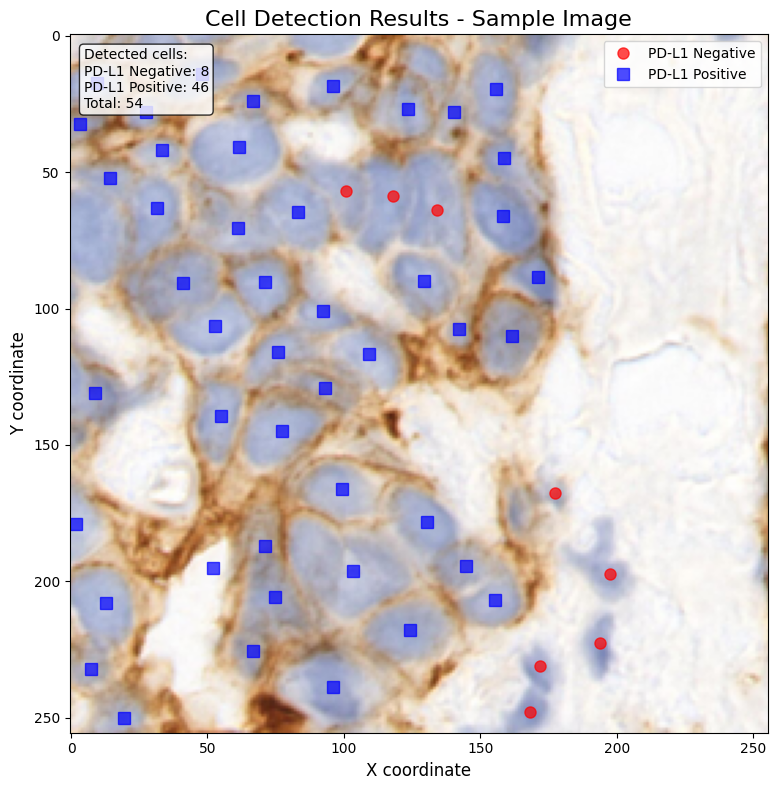

(<Figure size 800x800 with 1 Axes>,
 <Axes: title={'center': 'Cell Detection Results - Sample Image'}, xlabel='X coordinate', ylabel='Y coordinate'>)

In [4]:
image_list=glob('../../data/Patch-based-dataset/train_data_patch/class_2+/*.png')
img=Image.open(image_list[50]).resize((256,256))
torch_img=torch.from_numpy(np.array(img)[:,:,:3]).permute(2,0,1).unsqueeze(0).float()/255.
torch_img=torch_img.to(device)
model.eval()
with torch.no_grad():
    outputs=pred_patch(torch_img, model, 0, 0, 512/256)

visualize_detection_results(img, outputs, "Cell Detection Results - Sample Image")